# A Bayesian Approach to Document Embedding

## Background

The goal of our project is to use Bayesian techniques to embed documents into their vector representations. This field has been extensively studied and the approaches have used Neural Network based approaches. We try to bank on the paper [Bayesian Paragraph Vectors](https://robamler.github.io/files/ji-bayesian-paragraph-vectors-2017.pdf) which describes a novel technique with a custom loss function to obtain the embeddings. We train the model as described by Ji et. al on a new, smaller data set and perform criticism on the same.

## Introduction

We go through the [Box's Loop](https://www.jstor.org/stable/2286841) as follows:
1. Model: Model word vectors, latent context vectors and document embeddings
2. Inference: Infer posterior estimates of the document vectors
3. Criticism: Evaluate quality of document embeddings using criticism techniques specified below

We focus on the modelling aspect of the problem and analyze this Bayesian approach when the data size is limited. We evaluate our model by comparing it with Doc2Vec. More on this in the Criticism section. 

# Bayesian Paragraph Vectors

## Model

Ji et. al define the model as shown in the figure:
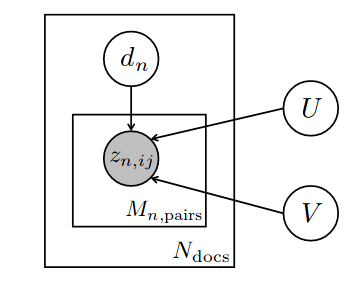

Given the common embedding size $E$ for word vectors, context vectors and document vectors, $U_i$ is the embedding of word $i$ in the vocabulary such that $U_i \in {\rm I\!R}^E$. Similarly, for every word $i$ we define a latent context embedding $V_i \in {\rm I\!R}^E$. These values are sampled from a Gaussian prior $V_i \sim \mathcal{N}(0,\lambda^2I)$ and $U_i \sim \mathcal{N}(0,\lambda^2I)$.

Now $d_i$ is defined as the document representation of docuemnt $i$ and is sampled from a Gaussian prior $d_i \sim\mathcal{N}(0,\phi^2I)$. 


```python
U_model = torch.distributions.MultivariateNormal(torch.zeros(W, E).cuda(), lamb**2 * torch.eye(E).cuda())
V_model = torch.distributions.MultivariateNormal(torch.zeros(W, E).cuda(), lamb**2 * torch.eye(E).cuda())
di_model = torch.distributions.MultivariateNormal(torch.zeros(E).cuda(), phi*torch.eye(E).cuda())```

$z_{i,j} \in \{0,1\}$ is defined as the label assigned to the word pair $(i,j)$ dependeing on if they occur together in context ($z_{i,j} = 1$) or not ($z_{i,j} = 0$).


For every word pair $(i,j)$, the likelihood of the pair in document $n$ is defined as below, where $\sigma(x) = \frac{1}{(1+e^{-x})}$

$$p(z_{n,i,j}|U_i,V_j,d_n) = \sigma(U_i^T(V_j + d_n))^{z_{n,i,j}} \sigma(-U_i^T(V_j + d_n))^{1-z_{n,i,j}}$$

To generate the word pairs for the training of U, V and d, the data is preprocessed as follow:

1. Positive Sampling: In each document $d_n$, a collection of positive samples $X_n^+$ is collected by forming pairs like $(w_{n,i},w_{n,i+\delta})$ where $\delta$ varies from -c to +c excpet $\delta=0$.

2. Negative Sampling: In each document $d_n$, a collection of negative samples $X_n^-$ is collected by forming 2c pairs for every word $w_{n,i}$ as $(w_{n,i},w)$ where w is sampled from a probability distribution of unigram frequency to the power of 3/4 ($P(w) \propto unigramfreq[w]^{\frac{3}{4}}$)

Thus, we end up with balanced dataset. 

## Inference

The loss function (log probability) for the inference step is defined as:

$$log p(X^+,X^-|U,V,d) = \sum_n \left[ \sum_{(i,j)\in X_n^+} log \sigma(U_i^T(V_j + d_n)) + \sum_{(i,j)\in X_n^-} log \sigma(-U_i^T(V_j + d_n)) \right]$$

The inference is split in 2 stages:
1. Stage 1: In this stage train U and V using stochastic gradient descent. For every step of the descent use a new document and iterate over the entire document list once. Before each step, sample $d_i \sim \mathcal{N}(0,\phi^2I)$ and optimize the loss over $d_i$ for the updated values of U and V. Once we have the optimized $d_i$ we proceed with the SGD step and update U, V. At the end of Stage I, we have point estimates for U and V.
2. Stage 2: Using the values of U and V from the previous stage, update the value of $d$ using Variational Inference. Once fit, estimate the value of $d$ using the posterior. These are the final document vectors. 

# Data Set

We use the BBC Text Document data [BBCFullTextDocument](http://mlg.ucd.ie/datasets/bbc.html) as document corpus to learn embeddings for. The data-set contains 2225 documents, each corresponding to one of five topics: business, entertainment, politics, sport, tech. 

The raw documents were then preprocessed by applied the following techniques:
1. Stemming (Porter algorithm)
2. Stop-word removal (stop word list)
3. Contraction expansion 
4. low term frequency filtering

# Criticism Techniques  

Now that we have described the modelling and inference techniques, we use the posterior to test the model against the data, identifying the ways that it succeeds and fails.  

We plan to use the following two metrics : 

* Performance of document vectors in downstream classification tasks.
* Embedding document vectors to lower dimension using t-SNE for visual criticism. 

### Source of truth :
We consider [doc2vec](https://cs.stanford.edu/~quocle/paragraph_vector.pdf) vectors that we trained on wikipedia data to be the golden standard for document vectors. When going through our criticism-experiment-update cycle we compare results of the criticism checks against the vectors obtained from doc2vec model.    

### Criticism Technique 1 : 
##### What ?
Performance of document vectors in downstream classification tasks.
##### How ?
We take a simple [logistic regression model](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) and perform 3-fold [cross validation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html) using the document vectors d_i.

```python
model = LogisticRegression()
cv_bpv = cross_validate(model, emb.tolist(), encoded_label, cv=3)
mean_score = np.mean(cv_bpv['test_score'])```

### Criticism Technique 2 : 
##### What ?
Embedding document vectors to lower dimension using t-SNE for visual criticism. 
##### How ?
The aim is to get a visual heuristic using which we can make quick judgements about the quality of the posterior estimates of the document vectors(d_i) that are being infered. 

We first embed the 100-dimension vector to 2-dimensions for ease of plotting using t-SNE (t-Distributed Stochastic Neighbor Embedding). The reason we chose this algorithm is because t-SNE minimizes the divergence between two distributions: a distribution that measures pairwise similarities of the input objects and a distribution that measures pairwise similarities of the corresponding low-dimensional points in the embedding. Hence, the stochastic neighbourhood of points is maintained. 

Using this low-dimension embedded vectors we plot the data while coloring each point with the label, or document type (ex: sports) that it came from. The belief is that documents from similar genres should be closer to each other in the embedded space. 


### How do the document vectors from doc2vec perform ?
* Criticism Technique 1 : Cross-validation with LogisticRegression performs as :
        

In [1]:
import warnings
import criticism_module
warnings.filterwarnings('ignore')

In [2]:
emb, labels = criticism_module.criticise_gold()

Doc2Vec classification performance :  0.9653966046815028



* Visual heuristic : Embedding document vectors to lower dimension using t-SNE and plotting gives us : 


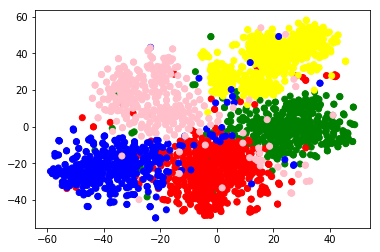

In [3]:
criticism_module.tsne_plot(emb, labels)

# Experiments

## Experiment 1

Following the method provided by Ji et. al, we started the first experiment by training $U$ and $V$ using Stochastic Gradient Descent, optimizing $d$ at every step. Further, using the learned values of $U$ and $V$, we trained SVI using an AutoDelta guide.

In [4]:
emb, labels = criticism_module.criticise('./expts/expt1/di')

Classification performance :  0.25078358896383734


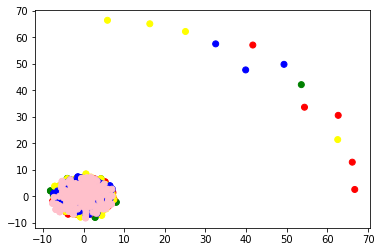

In [5]:
criticism_module.tsne_plot(emb, labels)

As it can be seen from the criticism steps, the document embeddings are not good. The prediction accuracy is as good as random. On seeing this, we started wondering where the problem was. We checked whether $U$ and $V$ were getting generated correctly. On checking similarity metrics of similar words (ex: reporter, media) using dot product of the word embeddings $U_{reporter},U_{media}$ we found that the similarity was very low.

In [6]:
# Call similarity measure

Thus, it was clear that $U$ and $V$ were not training correctly.

## Experiment 2

In the second experiment, we followed the intuition provided in the paper that if we set $d_i=0$ in the log probability and optimize over this new loss function, it is the same as Word2Vec. Thus, in the second experiment we expected the model to learn Word2Vec embeddings for the given data.

In [7]:
emb, labels = criticism_module.criticise('./expts/expt2/di')

Classification performance :  0.2377581401058381


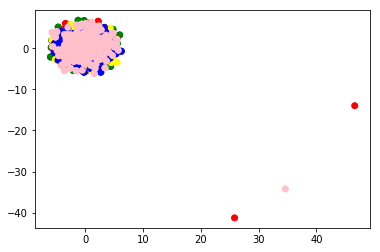

In [8]:
criticism_module.tsne_plot(emb, labels)

Visually we barely see a difference and the accuracy decreases. We still weren't able to train the $U$, $V$ vectors correctly. So for the next experiment, we decided to piggyback on the word embeddings from Word2Vec.

## Experiment 3

As mentioned above we generated $U$, i.e, the vectors for words in the vocabulary by picking their vectors from a pre-trained Word2Vec model (trained using Wikipedia corpus). Now keeping $U$ fixed, we trained on only $V$ like in Expeiment 1. At every iteration, we locally optimized $d$ and then made one SGD step for training $V$.

In [9]:
emb, labels = criticism_module.criticise('./expts/expt3/di')

Classification performance :  0.36721489149940867


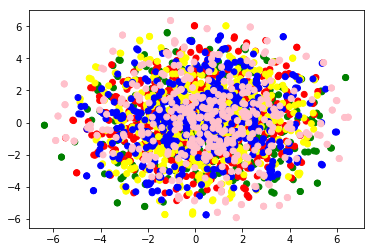

In [10]:
criticism_module.tsne_plot(emb, labels)

This time we got an even higher accuracy score (although it was still very low). This confirmed our intuition that a well trained $U$ and $V$ could in-fact generate great results. 

## Experiment 4

The final experiment had us completely piggybacking on the pre-trained Word2Vec model for $U$ and $V$ generation. This time, we set $V$ = $U$ = Word2Vec embeddings. Now, we skipped over the SGD step (Stage 1) and only ran the SVI for $d_i$ vector identification.

In [11]:
emb, labels = criticism_module.criticise('./expts/expt4/di')

Classification performance :  0.8808787458105622


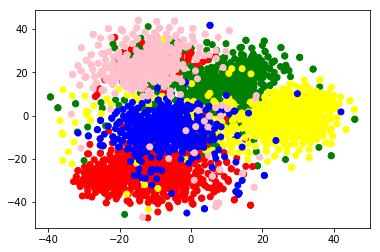

In [12]:
criticism_module.tsne_plot(emb, labels)

This experiment gave us the best results, which were quite comparable to doc2vec. It means that unless we have a big enough data, training $U$ and $V$ is really difficult. On the other hand once we have $U$ and $V$, the SVI algorithm extracts the document vectors really well.

# Conclusion

# References